In [31]:
import os
import requests
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import scipy.stats as sp
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import math

# Download & parse data from 2013 & 2014

In [32]:
# Read the file 'otc' & 'alpha'
url = 'https://snap.stanford.edu/data/soc-sign-bitcoinotc.csv.gz'
data = os.path.basename(url)
r = requests.get(url, allow_redirects=True)
open(data, 'wb').write(r.content)

url1 = 'https://snap.stanford.edu/data/soc-sign-bitcoinalpha.csv.gz'
data1 = os.path.basename(url1)
r1 = requests.get(url1, allow_redirects=True)
open(data1, 'wb').write(r1.content)

149480

In [33]:
cols = ['source', 'target', 'rating', 'time']

# parse the file: OTC
otc = pd.read_csv(data, names=cols, header=None)
otc['time'] = pd.to_datetime(otc.time * 1e9)
otc = otc.set_index(otc['time']).sort_index()
otc = otc['2013-01-01':'2014-12-31']

# Normalisation
for idx, row in otc.iterrows():
    otc.at[idx, 'rating'] = row.rating * 0.1

otc.head()

# parse the file: Alpha
alpha = pd.read_csv(data1, names=cols, header=None)
alpha['time'] = pd.to_datetime(alpha.time * 1e9)
alpha = alpha.set_index(alpha['time']).sort_index()
alpha = alpha['2013-01-01':'2014-12-31']

# Normalisation
for idx, row in alpha.iterrows():
    alpha.at[idx, 'rating'] = row.rating * 0.1

alpha.head()

,source,target,rating,time
time,,,,
2013-01-01 05:00:00,190,70,0.1,2013-01-01 05:00:00
2013-01-01 05:00:00,456,127,0.1,2013-01-01 05:00:00
2013-01-01 05:00:00,345,92,0.1,2013-01-01 05:00:00
2013-01-01 05:00:00,345,11,0.1,2013-01-01 05:00:00
2013-01-01 05:00:00,345,97,0.1,2013-01-01 05:00:00


In [34]:
otc.head()

,source,target,rating,time
time,,,,
2013-01-01 00:49:06.559320064,135,2877,-0.2,2013-01-01 00:49:06.559320064
2013-01-01 02:13:09.566249984,3239,2725,0.1,2013-01-01 02:13:09.566249984
2013-01-01 03:44:50.117110016,2188,2119,0.1,2013-01-01 03:44:50.117110016
2013-01-01 04:00:59.719859968,2028,2780,0.2,2013-01-01 04:00:59.719859968
2013-01-01 09:18:33.907480064,2780,2028,0.7,2013-01-01 09:18:33.907480064


Function to find max/min centrality nodes

In [35]:
def return_nodes(dic):
    max_cen = -math.inf
    max_node = 0

    min_cen = math.inf
    min_node = 0

    for k, v in dic.items():
        if v >= max_cen:
            max_cen = v
            max_node = k

        if v <= min_cen:
            min_cen = v
            min_node = k

    return max_node, min_node

# Group by weeks

In [36]:
# OTC: Count a week of a year
otc['week'] = otc.time.dt.isocalendar().week

# new dataframe for wk1-52 in 2013
otc13 = otc['2013-01-01':'2013-12-29']  # From 2013-12-30 -> 1st wk of 2014
wks = np.unique(otc13.week)  # 1-52
otc13 = otc13.set_index(otc13['week'])
otc13

# Save a group of dataframes grouped by week
df_otc13 = {}
for w in wks:
    df_otc13[w] = otc13.loc[w]

df_otc13

{1:       source  target  rating                          time  week
 week                                                            
 1        135    2877    -0.2 2013-01-01 00:49:06.559320064     1
 1       3239    2725     0.1 2013-01-01 02:13:09.566249984     1
 1       2188    2119     0.1 2013-01-01 03:44:50.117110016     1
 1       2028    2780     0.2 2013-01-01 04:00:59.719859968     1
 1       2780    2028     0.7 2013-01-01 09:18:33.907480064     1
 ...      ...     ...     ...                           ...   ...
 1       2725    2642     0.3 2013-01-06 18:27:02.266400000     1
 1       2524      23     0.1 2013-01-06 19:50:22.078560000     1
 1       3273    2898    -0.5 2013-01-06 20:23:41.032280064     1
 1       2725    1018     0.2 2013-01-06 21:47:01.950540032     1
 1       2419    2725     0.1 2013-01-06 21:53:51.373660160     1
 
 [179 rows x 5 columns],
 2:       source  target  rating                          time  week
 week                                      

In [37]:
# append nodes & edges in 2013 first
nodes_otc = []
edges_otc = []

for k in df_otc13.keys():
    # https://networkx.org/documentation/stable/reference/classes/multidigraph.html
    # https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html
    # Create a graph with the pandas dataframe
    g = nx.from_pandas_edgelist(df_otc13[k], 'source', 'target', edge_attr=['rating'], create_using=nx.MultiDiGraph())
    nodes_otc.append(g.number_of_nodes())
    edges_otc.append(g.number_of_edges())

In [38]:
# Create a dataframe for wk1-52 in 2014
otc14 = otc['2013-12-30':'2014-12-28']  # From '2014-12-29': wk1 of 2015
otc14 = otc14.set_index(otc14['week'])
# otc14

# Save a group of dataframes grouped by week
df_otc14 = {}
for w in wks:
    df_otc14[w] = otc14.loc[w]
df_otc14[53] = otc['2014-12-29':'2014-12-31']

In [39]:
# append nodes & edges in 2014
for k in df_otc14.keys():
    g = nx.from_pandas_edgelist(df_otc14[k], 'source', 'target', edge_attr=['rating'], create_using=nx.MultiDiGraph())
    nodes_otc.append(g.number_of_nodes())
    edges_otc.append(g.number_of_edges())

In [40]:
# ALPHA: Count a week of a year
alpha['week'] = alpha.time.dt.isocalendar().week

# new dataframe for wk1-52 in 2013
alpha13 = alpha['2013-01-01':'2013-12-29']  # From 2013-12-30 -> 1st wk of 2014
alpha13 = alpha13.set_index(alpha13['week'])

# Save a group of dataframes grouped by week
df_alpha13 = {}
for w in wks:
    df_alpha13[w] = alpha13.loc[w]

# append nodes & edges in 2013 first
nodes_alpha = []
edges_alpha = []

for k in df_alpha13.keys():
    # Create a graph with the pandas dataframe
    g = nx.from_pandas_edgelist(df_alpha13[k], 'source', 'target', edge_attr=['rating'], create_using=nx.MultiDiGraph())
    nodes_alpha.append(g.number_of_nodes())
    edges_alpha.append(g.number_of_edges())

# Create a dataframe for wk1-52 in 2014
alpha14 = alpha['2013-12-30':'2014-12-28']  # From '2014-12-29': wk1 of 2015
alpha14 = alpha14.set_index(alpha14['week'])

# Save a group of dataframes grouped by week
df_alpha14 = {}
for w in wks:
    df_alpha14[w] = alpha14.loc[w]
df_alpha14[53] = alpha['2014-12-29':'2014-12-31']

# append nodes & edges in 2014
for k in df_alpha14.keys():
    g = nx.from_pandas_edgelist(df_alpha14[k], 'source', 'target', edge_attr=['rating'], create_using=nx.MultiDiGraph())
    nodes_alpha.append(g.number_of_nodes())
    edges_alpha.append(g.number_of_edges())

In [41]:
lst = []
for i in range(1, 53):
    lst.append(i)

for i in range(1, 54):
    lst.append(i)

print(len(lst))
print(lst[::20])
# otc14.loc[49]

105
[1, 21, 41, 9, 29, 49]


# Basic statistics

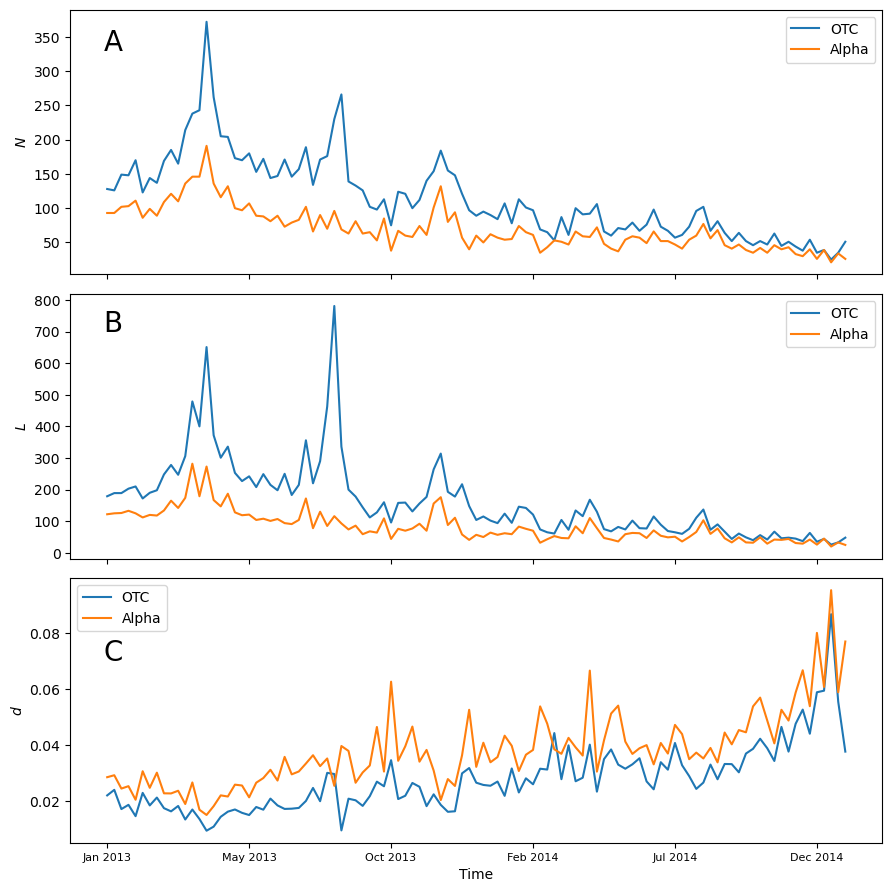

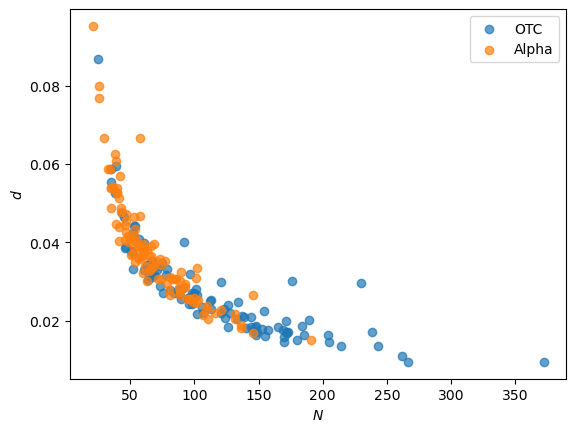

In [42]:
# Reference: The evolving liaisons between the transaction networks of Bitcoin and its price dynamics
label = ['Jan 2013', 'May 2013', 'Oct 2013', 'Feb 2014', 'Jul 2014', 'Dec 2014']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 9))

ax1.plot(nodes_otc, label='OTC')
ax1.plot(nodes_alpha, label='Alpha')
ax1.set_ylabel("N", style='italic')
ax1.legend()
ax1.text(x=-0.5, y=330, s='A', fontsize=20)
ax1.tick_params(axis='x', labelbottom=False)  # labels along the bottom edge are off
# ax1.set_title('Evolution of the number of nodes')


ax2.plot(edges_otc, label='OTC')
ax2.plot(edges_alpha, label='Alpha')
ax2.set_ylabel("L", style='italic')
ax2.legend()
ax2.text(x=-0.5, y=700, s='B', fontsize=20)
ax2.tick_params(axis='x', labelbottom=False)  # labels along the bottom edge are off
# ax2.set_title('Evolution of the number of links')


density_o = []
density_a = []
for i in range(len(nodes_otc)):
    # OTC
    rho1 = 2 * edges_otc[i] / (nodes_otc[i] * (nodes_otc[i] - 1))
    density_o.append(rho1)
    # Alpha
    rho2 = 2 * edges_alpha[i] / (nodes_alpha[i] * (nodes_alpha[i] - 1))
    density_a.append(rho2)
ax3.plot(density_o, label='OTC')
ax3.plot(density_a, label='Alpha')
ax3.set_xlabel("Time")
ax3.legend()
ax3.text(x=-0.5, y=0.07, s='C', fontsize=20)
ax3.set_ylabel("d", style='italic')
ax3.set_xticks(np.arange(0, 106, 20), label, fontsize=8)
# ax3.locator_params(axis='x', nbins=len(months)/6)
# ax3.set_title('Evolution of the link density')

fig.tight_layout(pad=1.0)
plt.show()

# N vs d
plt.scatter(nodes_otc, density_o, label='OTC', alpha=0.7)
plt.scatter(nodes_alpha, density_a, label='Alpha', alpha=0.7)
plt.ylabel('d', style='italic')
plt.xlabel('N', style='italic')
plt.legend()

plt.show()

# Degree Centrality

In [43]:
# https://networkx.org/documentation/stable/auto_examples/drawing/plot_directed.html#sphx-glr-auto-examples-drawing-plot-directed-py
# https://stackoverflow.com/questions/22967086/colouring-edges-by-weight-in-networkx
# https://www.tutorialspoint.com/colouring-the-edges-by-weight-in-networkx-matplotlib
def plot_centrality(graph, title):
    fig = plt.figure(figsize=(8, 6))

    degree_cen = nx.degree_centrality(graph)
    pos = nx.spring_layout(graph)

    cen = np.fromiter(degree_cen.values(), float)
    node_sizes = cen / np.max(cen) * 200
    normalize = mcolors.Normalize(vmin=cen.min(), vmax=cen.max())
    colormap = cm.RdYlGn  # https://matplotlib.org/stable/tutorials/colors/colormaps.html

    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(cen)

    edges, wt = zip(*nx.get_edge_attributes(graph, 'rating').items())
    for value in wt:
        value = (value + 1) / 2

    # normal_edge_wt = mcolors.Normalize(vmin=-1, vmax=1)
    # colormap_edge = cm.RdYlGn
    # scalarmap = cm.ScalarMappable(norm=normal_edge_wt, cmap = colormap_edge)
    # scalarmap.set_array(wt)

    plt.colorbar(scalarmappaple)
    nc = nx.draw_networkx_nodes(
        graph, pos, nodelist=graph.nodes(), node_size=node_sizes,
        node_color=node_sizes, cmap=colormap, alpha=0.8)  # linewidths=2.0,
    ec = nx.draw_networkx_edges(
        graph, pos, arrows=True, width=2,
        edge_color=wt, alpha=0.2)
    plt.title(f'Degree centrality in {title}')
    ax = plt.axis('off')

    plt.show()

In [44]:
g = nx.from_pandas_edgelist(otc['2013-01-01':'2013-12-31'], 'source', 'target', edge_attr=['rating'],
                            create_using=nx.MultiDiGraph())
wt = nx.get_edge_attributes(g, 'rating')
# for k in wt.keys():
#     wt[k] = (wt[k]+1)/2
# wt

# scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
# scalarmappaple.set_array(cen)

# wt = nx.get_edge_attributes(graph, 'rating')
# for k in wt.keys():
#     wt[k] = (wt[k]+1)/2


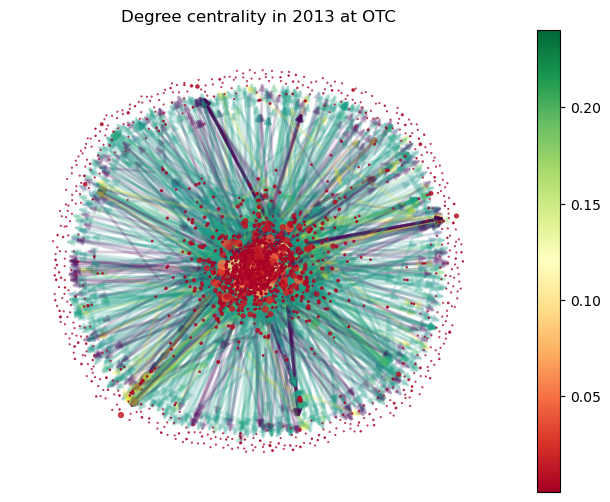

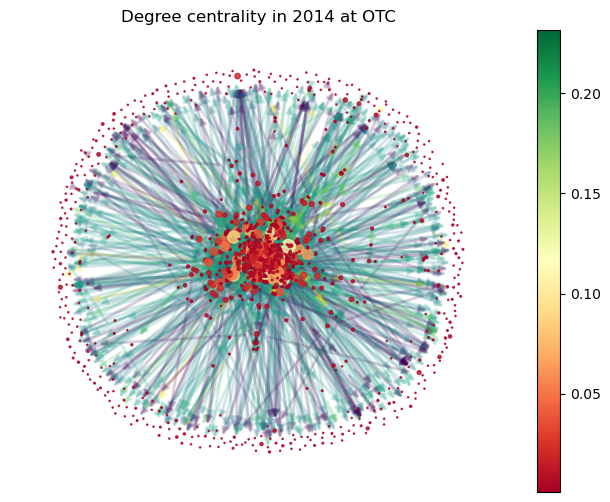

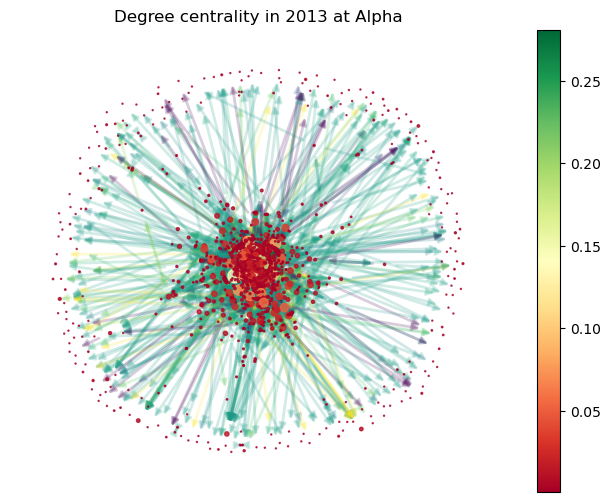

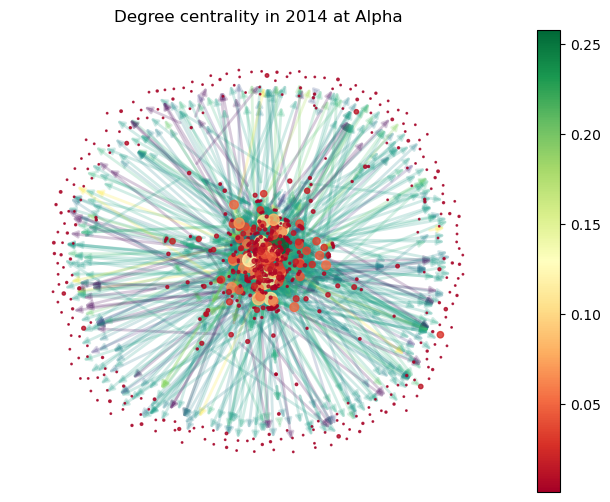

In [45]:
deg_max = []
deg_min = []
deg_in_max = []
deg_in_min = []
deg_out_max = []
deg_out_min = []
btn_max = []
btn_min = []
clo_max = []
clo_min = []
eig_max = []
eig_min = []

df_lst = [otc['2013-01-01':'2013-12-31'], otc['2014-01-01':'2014-12-31'], alpha['2013-01-01':'2013-12-31'],
          alpha['2014-01-01':'2014-12-31']]
title = ['2013', '2014']
platform = ['OTC', 'Alpha']

for i in range(4):
    g = nx.from_pandas_edgelist(df_lst[i], 'source', 'target', edge_attr=['rating'], create_using=nx.MultiDiGraph())
    # https://www.sciencedirect.com/topics/computer-science/degree-centrality
    # Centralities
    degree_cen = nx.degree_centrality(g)
    max_node, min_node = return_nodes(degree_cen)
    deg_max.append((max_node, degree_cen[max_node]))
    deg_min.append((min_node, degree_cen[min_node]))

    deg_cen_in = nx.in_degree_centrality(g)
    max_node_di, min_node_di = return_nodes(deg_cen_in)
    deg_in_max.append((max_node_di, deg_cen_in[max_node_di]))
    deg_in_min.append((min_node_di, deg_cen_in[min_node_di]))

    deg_cen_out = nx.out_degree_centrality(g)
    max_node_do, min_node_do = return_nodes(deg_cen_out)
    deg_out_max.append((max_node_do, deg_cen_out[max_node_do]))
    deg_out_min.append((min_node_do, deg_cen_out[min_node_do]))

    between_cen = nx.betweenness_centrality(g)
    max_node_b, min_node_b = return_nodes(between_cen)
    btn_max.append((max_node_b, between_cen[max_node_b]))
    btn_min.append((min_node_b, between_cen[min_node_b]))

    close_cen = nx.closeness_centrality(g)
    max_node_c, min_node_c = return_nodes(close_cen)
    clo_max.append((max_node_c, close_cen[max_node_c]))
    clo_min.append((min_node_c, close_cen[min_node_c]))

    # eigenvector centrality: 'power iteration failed to converge within 100 iterations')
    # NetworkXNotImplemented: not implemented for multigraph type
    g_e = nx.DiGraph(g)
    eigen_cen = nx.eigenvector_centrality(g_e)
    max_node_e, min_node_e = return_nodes(eigen_cen)
    eig_max.append((max_node_e, eigen_cen[max_node_e]))
    eig_min.append((min_node_e, eigen_cen[min_node_e]))

    if i < 2:
        plot_centrality(g, title[i % 2] + ' at ' + platform[0])
    else:
        plot_centrality(g, title[i % 2] + ' at ' + platform[1])

In [46]:
# Will put them in a table at the report / presentation file
print(deg_max)
print(deg_min)
print(deg_in_max)
print(deg_in_min)
print(deg_out_max)
print(deg_out_min)
print(btn_max)
print(btn_min)
print(clo_max)
print(clo_min)
print(eig_max)
print(eig_min)

[(2642, 0.2402088772845953), (3988, 0.23164335664335664), (3, 0.28074074074074074), (58, 0.257703081232493)]
[(5221, 0.0003729951510630362), (5877, 0.0008741258741258741), (3339, 0.0007407407407407407), (3417, 0.0014005602240896359)]
[(2642, 0.1215964192465498), (3988, 0.08216783216783216), (3, 0.14296296296296296), (58, 0.09103641456582633)]
[(1376, 0.0), (3829, 0.0), (7476, 0.0), (2400, 0.0)]
[(2642, 0.11861245803804552), (3988, 0.14947552447552448), (3, 0.13777777777777778), (58, 0.16666666666666666)]
[(5221, 0.0), (5877, 0.0), (3339, 0.0), (3417, 0.0)]
[(2642, 0.13188420825107242), (3988, 0.12672201377540115), (3, 0.1474906521215958), (58, 0.11754976801398126)]
[(5258, 0.0), (5877, 0.0), (3339, 0.0), (3417, 0.0)]
[(2642, 0.32919429124546706), (4291, 0.23615110379816262), (3, 0.35196597325186085), (19, 0.24660833971198667)]
[(1376, 0.0), (3829, 0.0), (7476, 0.0), (2400, 0.0)]
[(2642, 0.36189240082237256), (4291, 0.24830879263578118), (3, 0.35897222830944686), (19, 0.2468203364631363

# Community Detection

## Leiden Algorithm

In [47]:
# https://www.nature.com/articles/s41598-019-41695-z
# https://github.com/KangboLu/Graph-Analysis-with-NetworkX/blob/main/05_community_detection.ipynb
import leidenalg
import igraph as ig
import networkx.algorithms.community as nx_comm


# function to obtain the communities calculated by leiden algorithm
def get_leiden_communities(graph, random_state=0):
    if isinstance(graph, (nx.Graph, nx.OrderedDiGraph, nx.DiGraph, nx.OrderedGraph)):
        graph = ig.Graph.from_networkx(graph)
    return list(leidenalg.find_partition(graph,
                                         partition_type=leidenalg.ModularityVertexPartition,
                                         seed=random_state))

In [48]:
# convert community dictionary to a list of community node lists
# made for Louvain output and Leiden output
def convert_communities_dict_to_list(communities_dict):
    unique_partition_count = len(list(set(communities_dict.values())))
    print("Number of unique communities:", unique_partition_count)
    communities = [[] for i in range(unique_partition_count)]
    for node in communities_dict.keys():
        communities[communities_dict[node]].append(node)
    return communities

In [49]:
# function to check whether the determined communities are connected
def check_community_disconnection(graph, communities):
    total_connected = 0
    disconnected_community_indexes = []
    for i in range(len(communities)):
        if nx.is_connected(graph.subgraph(communities[i])):
            total_connected += 1
        else:
            disconnected_community_indexes.append(i)
    print("Total Communities:", len(communities))
    print("Total Communities Connected:", total_connected)
    print("Disconnected Community Indexes:", disconnected_community_indexes)

In [50]:
def leiden(graph, title):
    temp_graph = ig.Graph.from_networkx(graph)

    leiden_communities = leidenalg.find_partition(temp_graph,
                                                  partition_type=leidenalg.ModularityVertexPartition,
                                                  seed=0)

    leiden_communities_dict = dict(zip(temp_graph.vs["_nx_name"], leiden_communities.membership))
    leiden_communities_list = convert_communities_dict_to_list(leiden_communities_dict)

    community_sizes = pd.DataFrame([len(community) for community in leiden_communities_list],
                                   columns=["community_size"])
    community_sizes.plot.hist(bins=40, figsize=(8, 5), title=f"Community Size Distribution for {title}")

    print("Modularity:",
          round(nx_comm.modularity(graph, leiden_communities_list), 6))

    check_community_disconnection(graph, leiden_communities_list)

Nodes 2013 at OTC: 2682 / Edges 2013 at OTC: 8224
Number of unique communities: 16
Modularity: 0.507117
Total Communities: 16
Total Communities Connected: 16
Disconnected Community Indexes: []

Nodes 2014 at OTC: 1145 / Edges 2014 at OTC: 2873
Number of unique communities: 32
Modularity: 0.520049
Total Communities: 32
Total Communities Connected: 32
Disconnected Community Indexes: []

Nodes 2013 at Alpha: 1351 / Edges 2013 at Alpha: 3740
Number of unique communities: 21
Modularity: 0.476814
Total Communities: 21
Total Communities Connected: 21
Disconnected Community Indexes: []

Nodes 2014 at Alpha: 715 / Edges 2014 at Alpha: 1869
Number of unique communities: 24
Modularity: 0.508055
Total Communities: 24
Total Communities Connected: 24
Disconnected Community Indexes: []



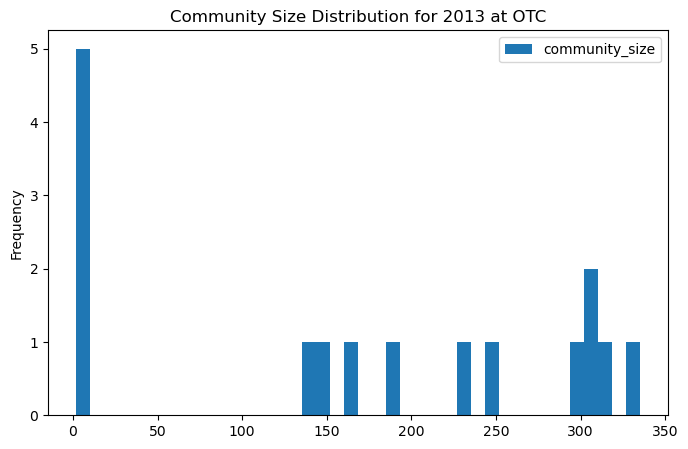

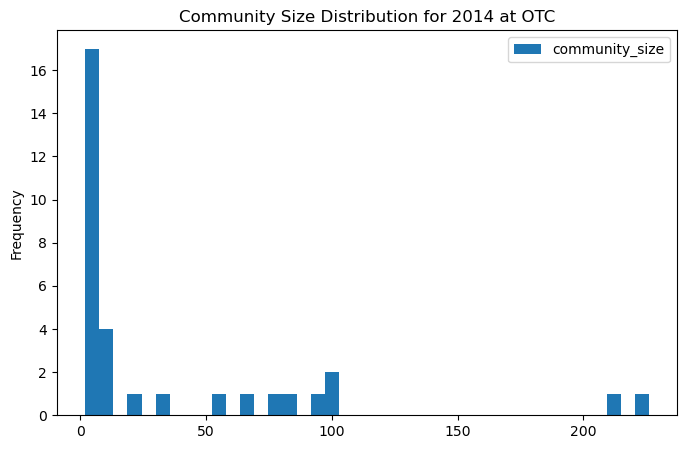

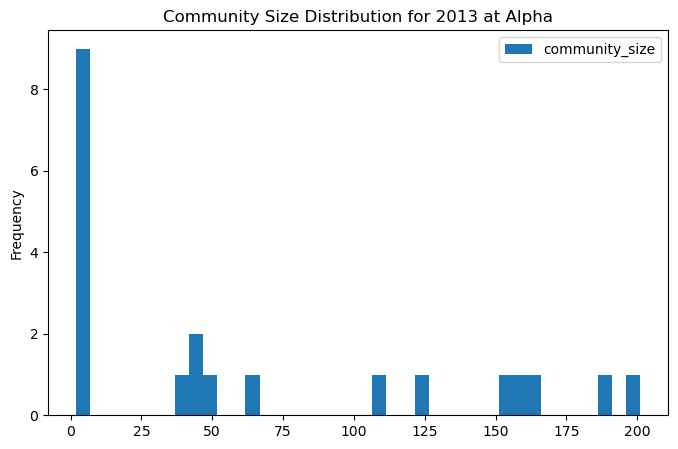

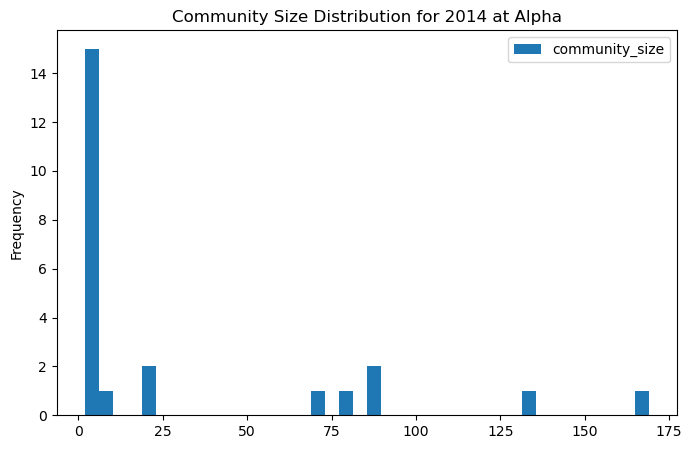

In [51]:
df_lst = [otc['2013-01-01':'2013-12-31'], otc['2014-01-01':'2014-12-31'], alpha['2013-01-01':'2013-12-31'],
          alpha['2014-01-01':'2014-12-31']]
title = ['2013', '2014']
platform = ['OTC', 'Alpha']

for i in range(4):
    # Load undirected graph
    g = nx.from_pandas_edgelist(df_lst[i], 'source', 'target', edge_attr=['rating'])

    if i < 2:
        print(
            f"Nodes {title[i % 2] + ' at ' + platform[0]}: {g.number_of_nodes()} / Edges {title[i % 2] + ' at ' + platform[0]}: {g.number_of_edges()}")
        leiden(g, title[i % 2] + ' at ' + platform[0])
    else:
        print(
            f"Nodes {title[i % 2] + ' at ' + platform[1]}: {g.number_of_nodes()} / Edges {title[i % 2] + ' at ' + platform[1]}: {g.number_of_edges()}")
        leiden(g, title[i % 2] + ' at ' + platform[1])

    print("")